# **0. 대회 소개**


- [대회 링크](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)
- 시계열 예측을 사용하여 에콰도르 기반의 대형 식료품 소매업체인 Corporación Favorita의 `매장 판매량`을 예측하고자 함
  - Favorita 매장에서 판매되는 수천 개 제품들의 `단위 판매량`을 제품군 별로 더 정확하게 예측하는 모델을 구축하고자 함


**평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$: 인스턴스 $i$에 대한 타겟의 실제값

# **1. 데이터 불러오기**

In [25]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,487 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and dire

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format # 소수점 둘째자리까지만 표시

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/test_preprocessed.csv')

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,93.14,0.00,National
1,1,2013-01-01,41,SEAFOOD,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
2,2,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
3,3,2013-01-01,41,PRODUCE,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
4,4,2013-01-01,41,PREPARED FOODS,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday


# **2. EDA**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   float64
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday       object 
dtypes: float64(4), int64(3), object(6)
memory usage: 268.3+ MB


In [7]:
train.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type               0
cluster            0
dcoilwtico         0
transactions    3778
holiday            0
dtype: int64

In [8]:
train.describe()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,2705087.00,2705087.00,2705087.00,2705087.00,2705087.00,2705087.00,2701309.00
mean,1352543.00,26.80,396.90,2.89,8.54,66.59,1683.18
std,780891.50,15.61,1153.98,12.84,4.73,25.49,972.75
min,0.00,1.00,0.00,0.00,1.00,26.19,0.00
25%,676271.50,13.00,1.00,0.00,4.00,46.12,1039.00
50%,1352543.00,27.00,19.00,0.00,9.00,52.71,1392.00
75%,2028814.50,40.00,239.15,0.00,13.00,95.14,2076.00
max,2705086.00,54.00,124717.00,741.00,17.00,110.62,8359.00


## **(1) 시간(date)에 따른 매출(sales)**

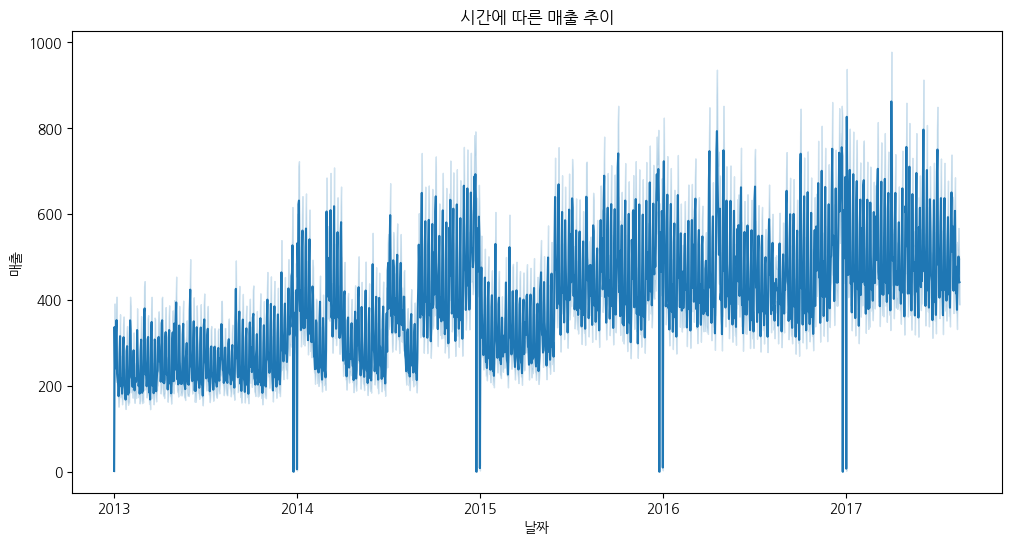

In [9]:
# 'date' 열을 날짜 형식으로 변환
train['date'] = pd.to_datetime(train['date'])

# 날짜를 기준으로 데이터 정렬
train.sort_values('date', inplace=True)

# 시간에 따른 매출 추이 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=train)
plt.title('시간에 따른 매출 추이')
plt.xlabel('날짜')
plt.ylabel('매출')
plt.show()

>> 계속 증가하고 있는 추세

>> 연초에 매출이 훅 떨어지는 것은 휴업의 영향으로 보임

>> 1년 단위로 보면 연말에 매출이 비교적 많은 것으로 보임

## **(2) 매장(store_nbr) 간 매출(sales) 비교**

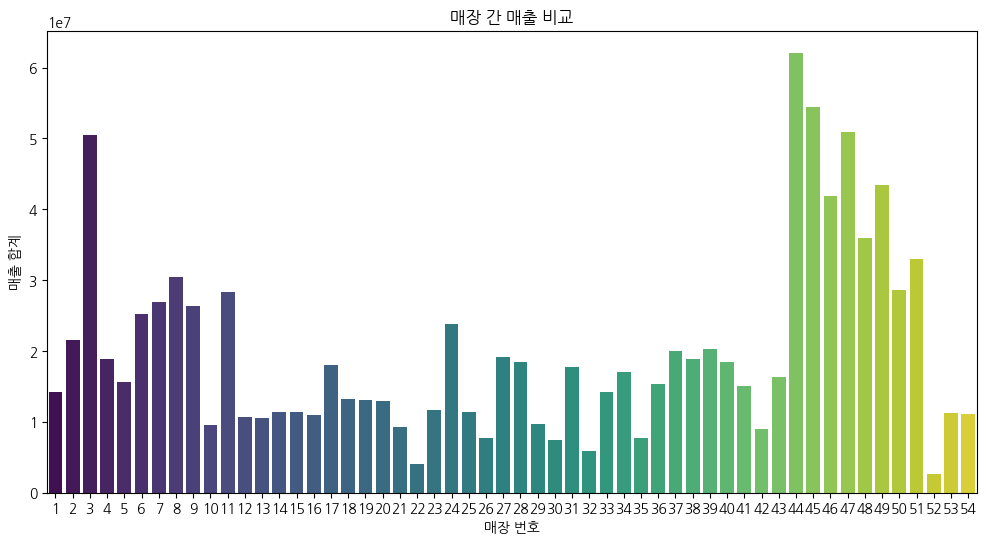

In [10]:
# 매장 번호(store_nbr)를 기준으로 그룹화하여 매출의 합을 계산
store_sales = train.groupby('store_nbr')['sales'].sum().reset_index()

# 매장 간 매출 비교 막대 그래프 생성
plt.figure(figsize=(12, 6))
sns.barplot(x='store_nbr', y='sales', data=store_sales, palette='viridis')
plt.title('매장 간 매출 비교')
plt.xlabel('매장 번호')
plt.ylabel('매출 합계')
plt.show()

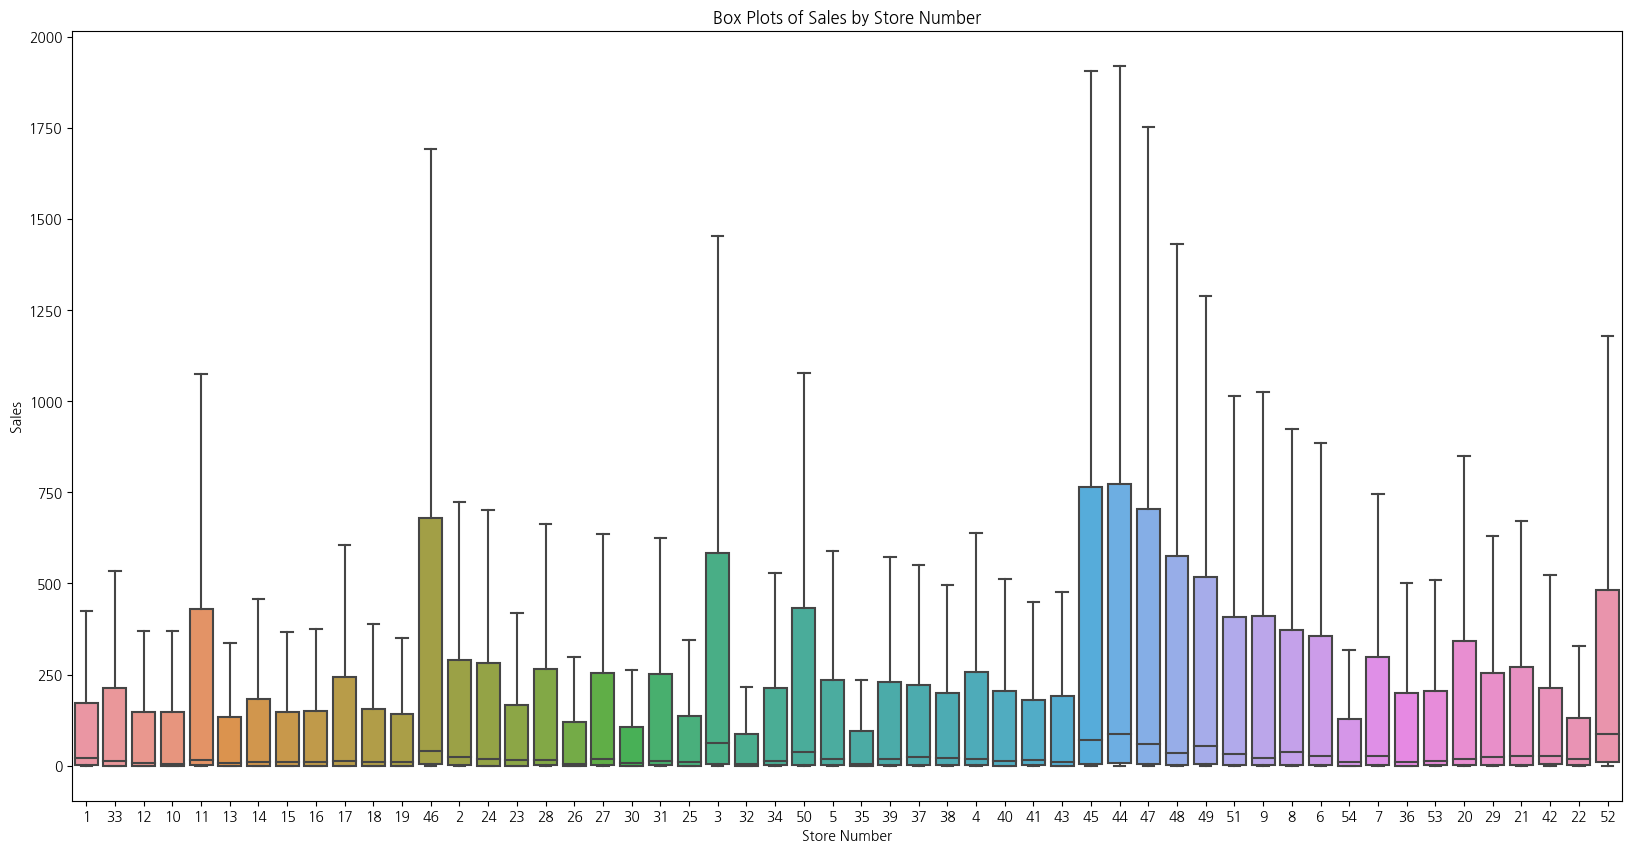

In [33]:
plt.figure(figsize=(20,10))
sns.boxplot(x=train['store_nbr'].astype(str), y=train['sales'], showfliers = False)

plt.xlabel('Store Number')
plt.ylabel('Sales')

plt.title('Box Plots of Sales by Store Number')
plt.show()

>> 44, 45, 3, 49, 46번의 매장이 매출이 높음

>> 매장 별로 매출이 많이 차이나는 것을 볼 수 있음

## **(3) 상품군(family)에 따른 매출 분포 시각화**

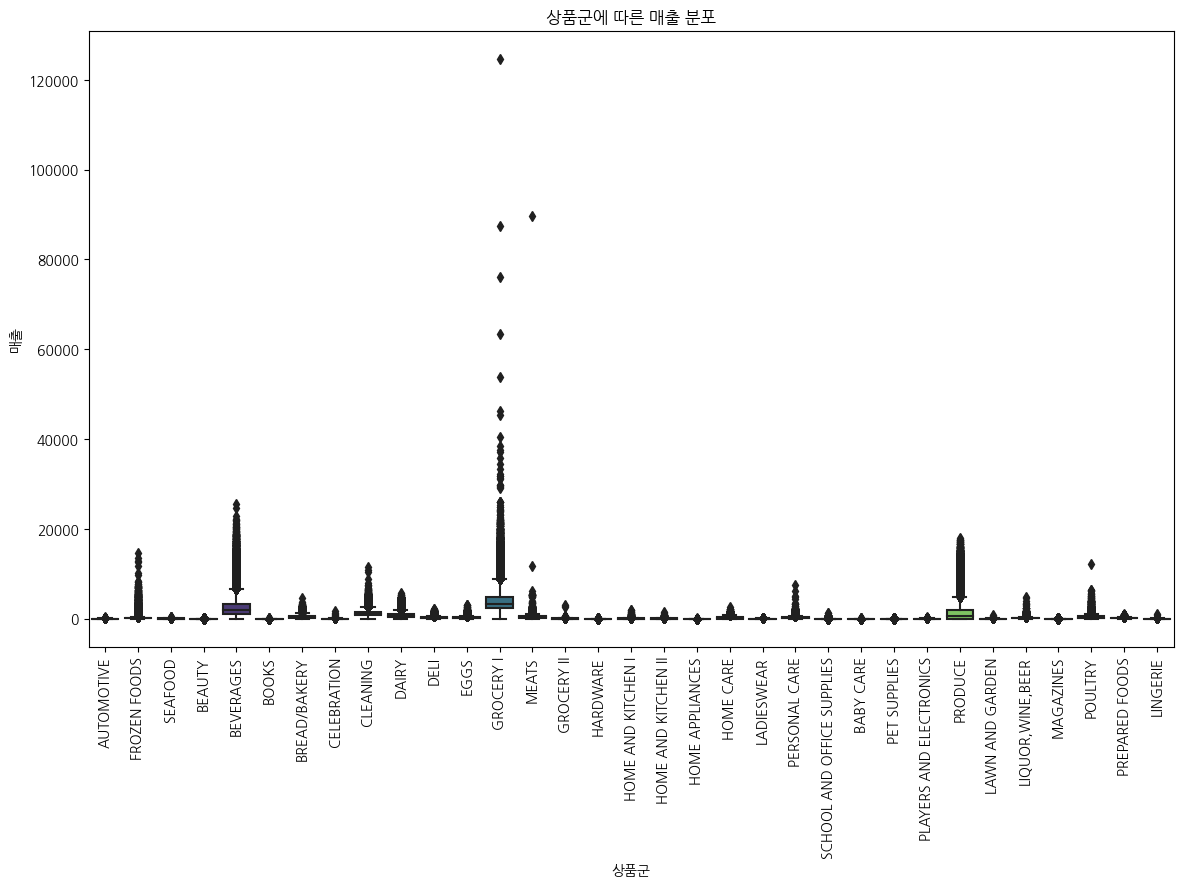

In [13]:
# 상품군(family)을 기준으로 그룹화하여 상자 그림 생성
plt.figure(figsize=(14, 8))
sns.boxplot(x='family', y='sales', data=train, palette='viridis')
plt.title('상품군에 따른 매출 분포')
plt.xlabel('상품군')
plt.ylabel('매출')
plt.xticks(rotation=90)  # x축 레이블 회전
plt.show()

>> GROCERY I의 매출 평균이 가장 높으며 이상치가 매우 높고 많음

>> 자세히 살피기 위해 GROCERY I, MEATS를 제외한 상품군 그래프 그리기

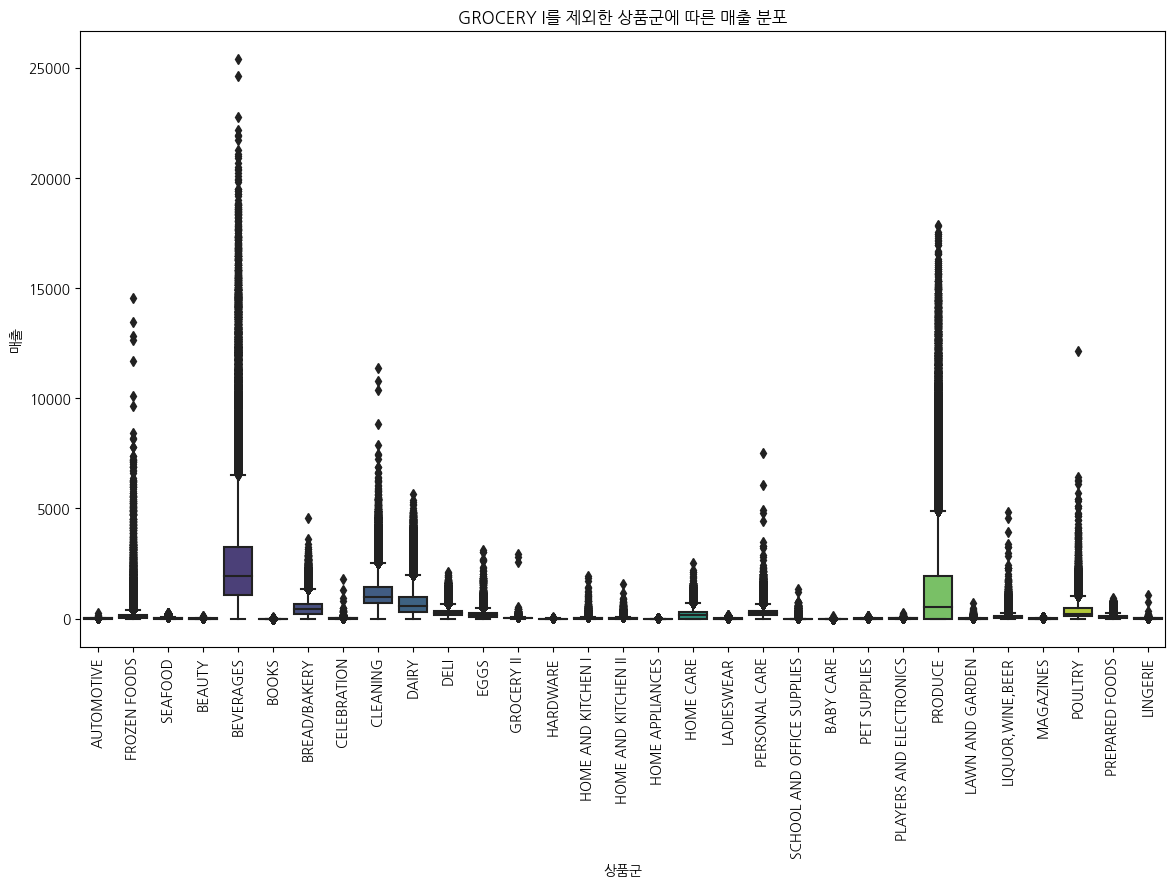

In [15]:
# 상품군(family)을 기준으로 그룹화하여 상자 그림 생성 - GROCERY I, MEATS 제외

# GROCERY I를 제외한 데이터 생성
df_exclude = train[(train['family'] != 'GROCERY I') & (train['family'] != 'MEATS')]

# 상품군(family)을 기준으로 그룹화하여 상자 그림 생성
plt.figure(figsize=(14, 8))
sns.boxplot(x='family', y='sales', data=df_exclude, palette='viridis')
plt.title('GROCERY I를 제외한 상품군에 따른 매출 분포')
plt.xlabel('상품군')
plt.ylabel('매출')
plt.xticks(rotation=90)  # x축 레이블 회전
plt.show()

>> 대부분의 상품군들이 매출 이상치가 존재함

>> 이상치가 매우 많기 때문에 이름 처리해야할 필요가 있는지는 모르겠음

## **(4) 휴일(holiday) 여부 및 종류에 따른 매출 비교**

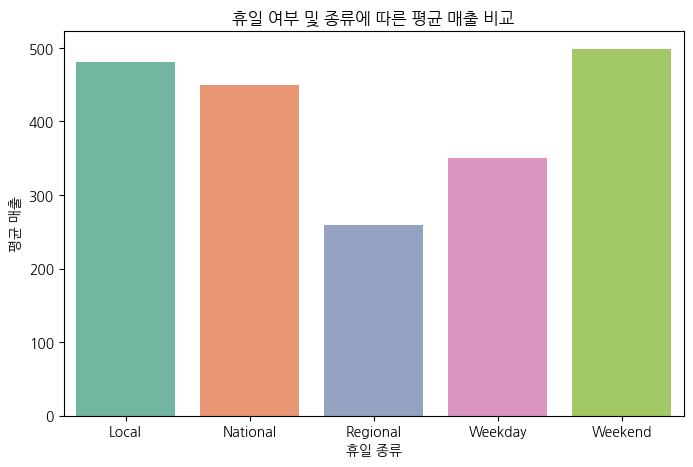

In [25]:
# 휴일 종류에 따라 데이터 그룹화
holiday_avg_sales = train.groupby('holiday')['sales'].mean().reset_index()

# 막대 그래프 생성
plt.figure(figsize=(8, 5))
sns.barplot(x='holiday', y='sales', data=holiday_avg_sales, palette='Set2')
plt.title('휴일 여부 및 종류에 따른 평균 매출 비교')
plt.xlabel('휴일 종류')
plt.ylabel('평균 매출')
plt.show()


>> 주말에 가장 평균매출이 높음

>> 'Local'이나 'National'과 같은 휴일에 평일보다 평균매출이 높음

>> 'Regional' 휴일에 가장 평균매출이 적음

## **(5) 원유 가격과 매출의 상관관계**

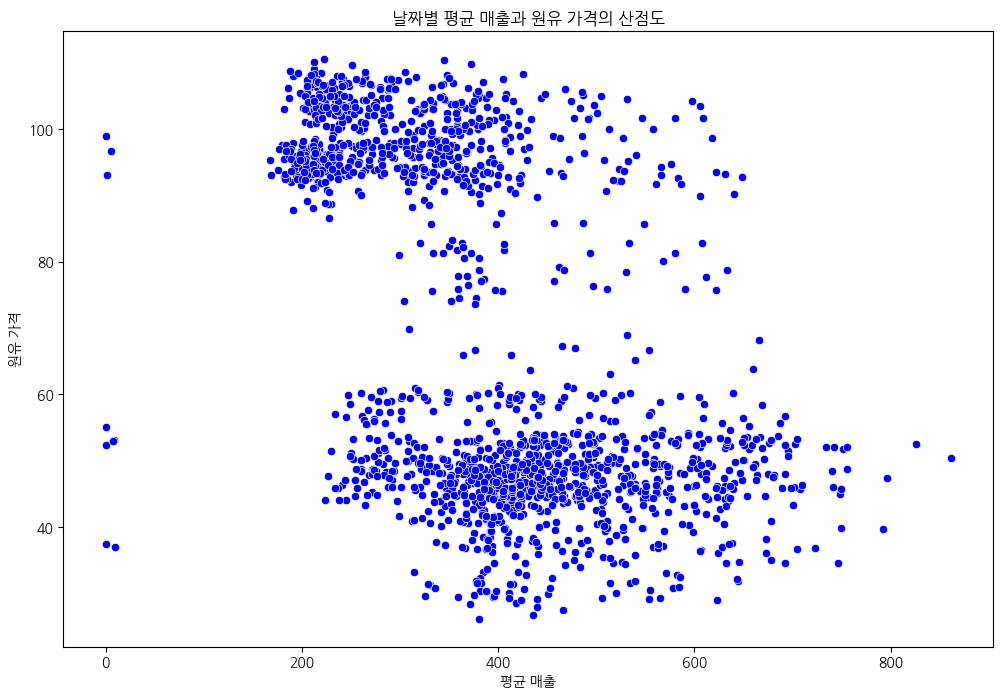

In [41]:
# 'date'를 날짜 형식으로 변환
train['date'] = pd.to_datetime(train['date'])

# 날짜별 평균 매출과 원유 가격의 산점도 생성
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sales', y='dcoilwtico', data=train.groupby('date').agg({'sales':'mean', 'dcoilwtico':'mean'}).reset_index(), color='blue')
plt.title('날짜별 평균 매출과 원유 가격의 산점도')
plt.xlabel('평균 매출')
plt.ylabel('원유 가격')
plt.show()


>> 원유 가격과 매출 사이에 뚜렷한 관계가 보이지 않음

## **(6) 유가 시계열 그래프**

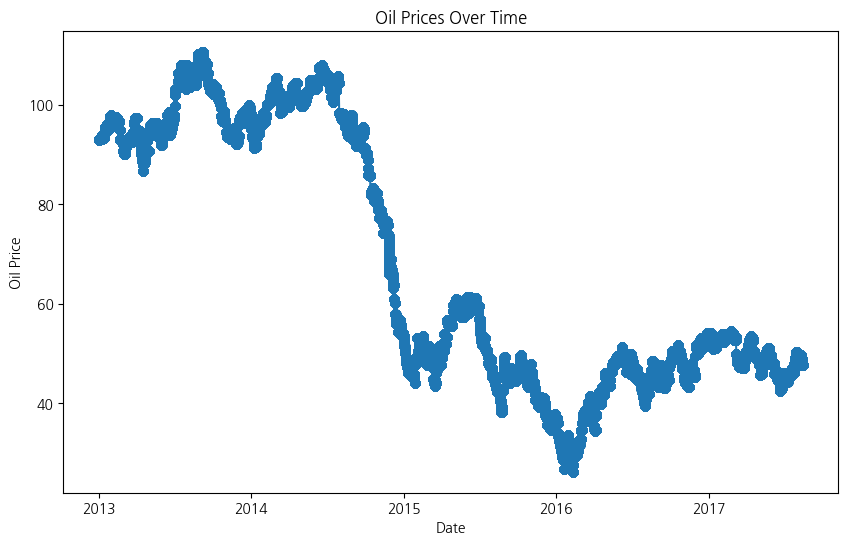

In [31]:
# 유가 시계열 그래프
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['dcoilwtico'], marker='o', linestyle='-')
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

>> 변동이 매우 큼

>> 시간이 지남에 따라 증가하는 것이 아님

## **(7) 원유 가격과 평균 매출 시계열 그래프**

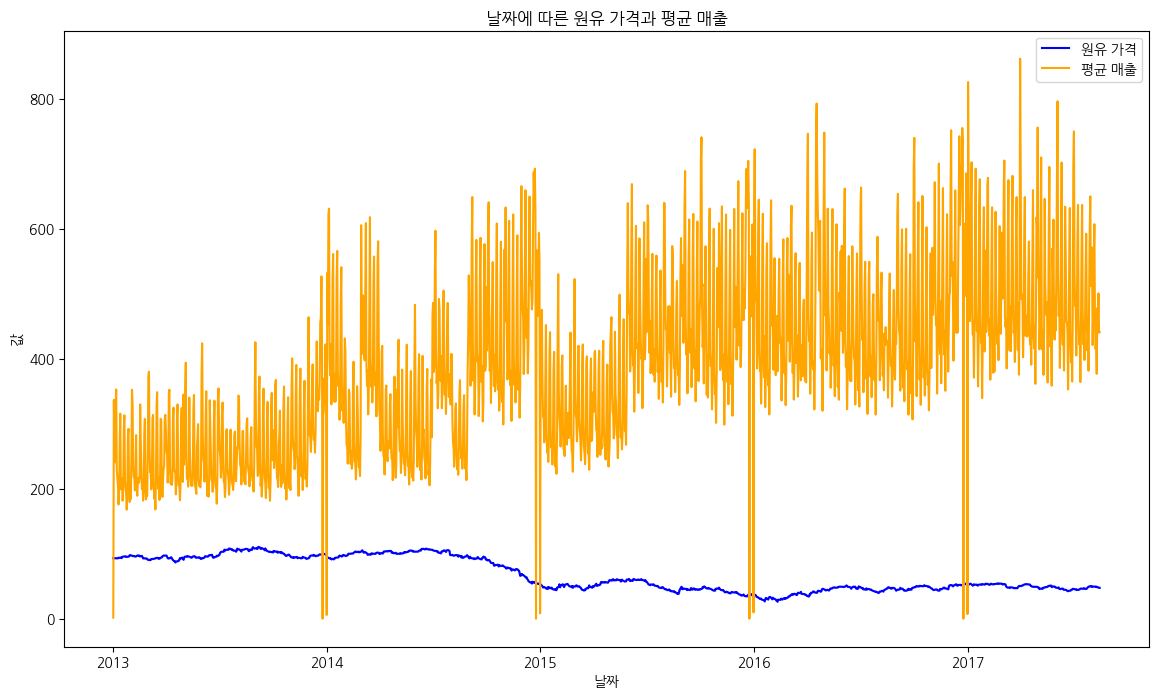

In [32]:
# 'date'를 날짜 형식으로 변환
train['date'] = pd.to_datetime(train['date'])

# 날짜에 따른 원유 가격과 평균 매출 선 그래프 생성
plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='dcoilwtico', data=train, label='원유 가격', color='blue')
sns.lineplot(x='date', y='sales', data=train.groupby('date')['sales'].mean().reset_index(), label='평균 매출', color='orange')
plt.title('날짜에 따른 원유 가격과 평균 매출')
plt.xlabel('날짜')
plt.ylabel('값')
plt.legend()
plt.show()

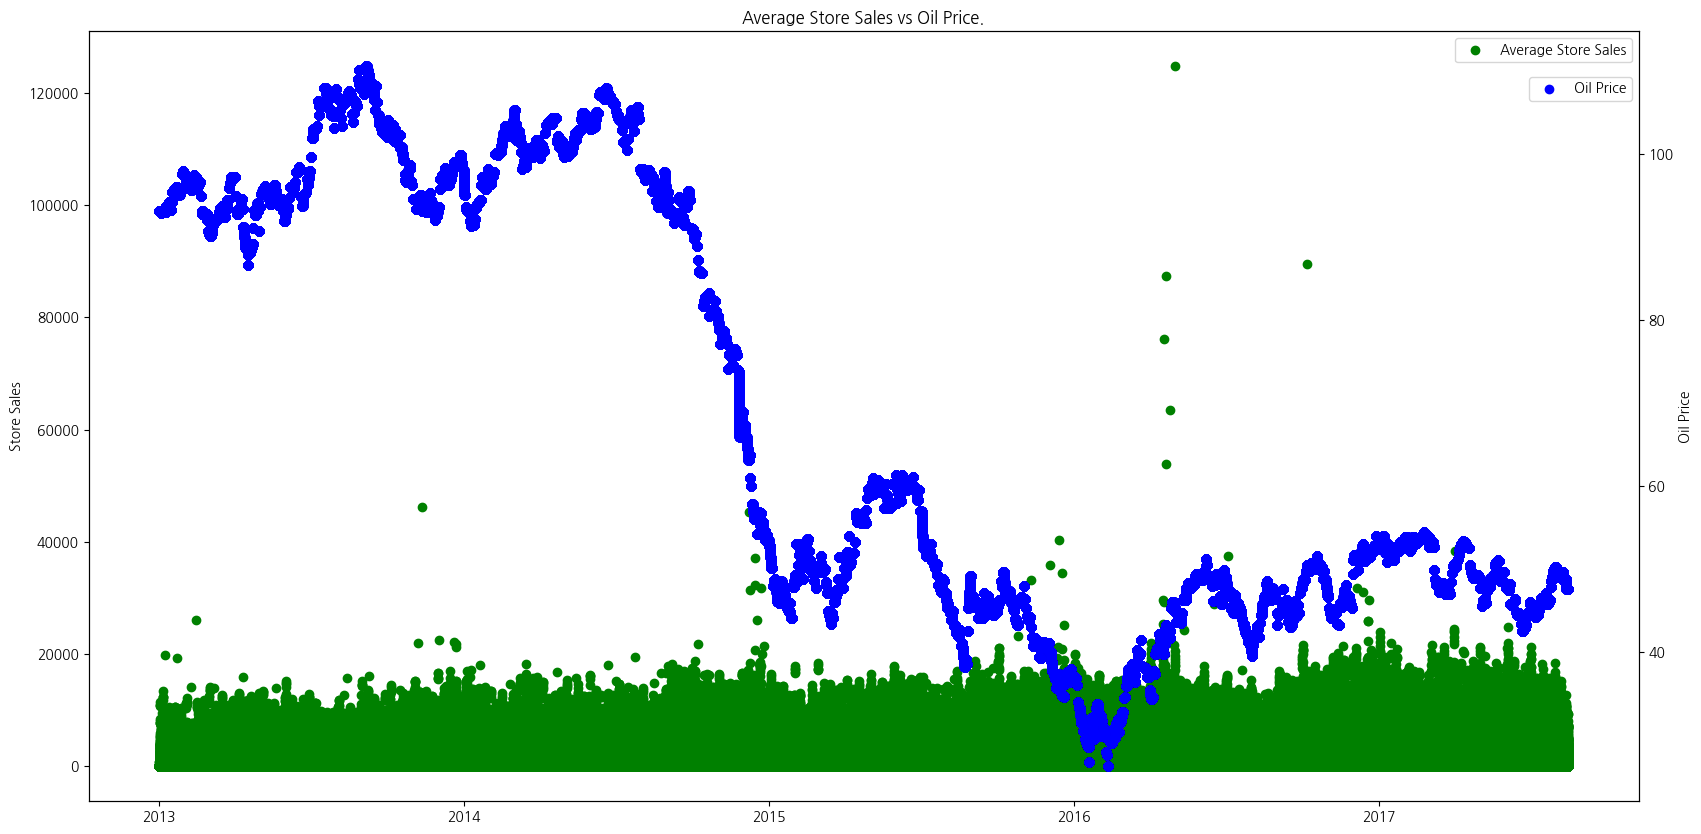

In [39]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()

ax1.scatter(train['date'], train['sales'], color="g", label='Store Sales')
ax1.set_ylabel('Store Sales')

ax2.scatter(train['date'], train['dcoilwtico'], color="b", label='Oil Price')
ax2.set_ylabel('Oil Price')

ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,0.95))

plt.title(f'Average Store Sales vs Oil Price.')
plt.show()

>> 관계가 전혀 없음..?